# 04 - Time Series Forecasting - Data Review in BigQuery

This series will explore forecasting with Vertex AI and BigQuery.  Forecasting is following a measurement over time and exploring trends, the impact of seasonality (years, months, days, etc), holidays, and special events with the hope of using these insights to forecast into the near future.  Before we look into methods of forecasting, this notebook will first look at a data source with a time element.  

This series will use bike Citibike rentals in New York city.  The bike stations near central park will be selected and the daily number bike trips that orignate from these stations will be followed over time.  This will be complicated as new stations are introduced over time and some stations only have the most recent few months, or just weeks of data.  

In this notebook we look at the data available and visualize the trend over time.

### Prerequisites:
-  None

### Overview:
- Setup
- Data Setup
- Propose Train/Validation/Test Splits by Date Range
- Create Source BigQuery Table for Forecasting
- Review Forecasting Data
- Validation Check: Extract dates for splits from source
- Validation Check: Duplicate dates at stations?
- Time Series Review

### Resources:
- [How to do time series forecasting in BigQuery](https://towardsdatascience.com/how-to-do-time-series-forecasting-in-bigquery-af9eb6be8159)

---
## Vertex AI - Conceptual Flow

<img src="architectures/slides/04_arch.png">

---
## Vertex AI - Workflow

<img src="architectures/slides/04_console.png">

---
## Setup

inputs:

In [46]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [47]:
REGION = 'us-central1'
DATANAME = 'citibikes'
NOTEBOOK = '04'

BQ_SOURCE = 'bigquery-public-data.new_york.citibike_trips'

packages:

In [48]:
from google.cloud import bigquery

import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

clients:

In [49]:
bq = bigquery.Client()

---
## BigQuery From Jupyter!

### BigQuery Cell Magic

In [77]:
%%bigquery
SELECT *
FROM bigquery-public-data.new_york.citibike_trips
LIMIT 5

Downloading: 100%|██████████| 5/5 [00:02<00:00,  2.47rows/s]


,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,10274,2016-04-24 22:36:40+00:00,2016-04-25 01:27:54+00:00,263,Elizabeth St & Hester St,40.717290,-73.996375,3240,NYCBS Depot BAL - DYR,0.000000,0.000000,16458,Customer,NaN,unknown
1,111769,2016-02-08 19:27:15+00:00,2016-02-10 02:30:04+00:00,249,Harrison St & Hudson St,40.718710,-74.009001,3240,NYCBS Depot BAL - DYR,0.000000,0.000000,16860,Subscriber,1966.0,male
2,547,2016-05-02 17:52:21+00:00,2016-05-02 18:01:29+00:00,514,12 Ave & W 40 St,40.760875,-74.002777,3240,NYCBS Depot BAL - DYR,0.000000,0.000000,22094,Subscriber,1975.0,male
3,152978,2016-02-22 19:22:07+00:00,2016-02-24 13:51:46+00:00,250,Lafayette St & Jersey St,40.724561,-73.995653,3019,NYCBS Depot - DEL,40.716633,-73.981933,17943,Subscriber,1969.0,male
4,100569,2015-12-17 10:24:19+00:00,2015-12-18 14:20:29+00:00,417,Barclay St & Church St,40.712912,-74.010202,3019,NYCBS Depot - DEL,40.716633,-73.981933,22674,Subscriber,1989.0,male


### BigQuery Python Client

In [78]:
query = f"""
    SELECT * 
    FROM `{BQ_SOURCE}`
    LIMIT 5
"""
preview = bq.query(query = query).to_dataframe()
preview

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,134,2016-04-11 18:15:31+00:00,2016-04-11 18:17:45+00:00,520,W 52 St & 5 Ave,40.759923,-73.976485,520,W 52 St & 5 Ave,40.759923,-73.976485,17697,Subscriber,1988.0,male
1,130,2016-08-05 19:41:30+00:00,2016-08-05 19:43:40+00:00,520,W 52 St & 5 Ave,40.759923,-73.976485,520,W 52 St & 5 Ave,40.759923,-73.976485,16177,Subscriber,1989.0,male
2,69,2013-10-26 17:00:24+00:00,2013-10-26 17:01:33+00:00,520,W 52 St & 5 Ave,40.759923,-73.976485,520,W 52 St & 5 Ave,40.759923,-73.976485,18263,Subscriber,1957.0,male
3,644,2016-08-29 13:14:35+00:00,2016-08-29 13:25:20+00:00,520,W 52 St & 5 Ave,40.759923,-73.976485,520,W 52 St & 5 Ave,40.759923,-73.976485,24139,Customer,NaN,unknown
4,1212,2016-07-20 11:55:56+00:00,2016-07-20 12:16:09+00:00,520,W 52 St & 5 Ave,40.759923,-73.976485,520,W 52 St & 5 Ave,40.759923,-73.976485,24107,Subscriber,1962.0,male


### BigQuery Python Client: Helper Function

In [79]:
def bq_runner(query):
    return bq.query(query = query)

In [80]:
bq_runner(
    query = f"""
        SELECT * 
        FROM `{BQ_SOURCE}`
        LIMIT 5
    """
).to_dataframe()

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,10274,2016-04-24 22:36:40+00:00,2016-04-25 01:27:54+00:00,263,Elizabeth St & Hester St,40.717290,-73.996375,3240,NYCBS Depot BAL - DYR,0.000000,0.000000,16458,Customer,NaN,unknown
1,111769,2016-02-08 19:27:15+00:00,2016-02-10 02:30:04+00:00,249,Harrison St & Hudson St,40.718710,-74.009001,3240,NYCBS Depot BAL - DYR,0.000000,0.000000,16860,Subscriber,1966.0,male
2,547,2016-05-02 17:52:21+00:00,2016-05-02 18:01:29+00:00,514,12 Ave & W 40 St,40.760875,-74.002777,3240,NYCBS Depot BAL - DYR,0.000000,0.000000,22094,Subscriber,1975.0,male
3,152978,2016-02-22 19:22:07+00:00,2016-02-24 13:51:46+00:00,250,Lafayette St & Jersey St,40.724561,-73.995653,3019,NYCBS Depot - DEL,40.716633,-73.981933,17943,Subscriber,1969.0,male
4,100569,2015-12-17 10:24:19+00:00,2015-12-18 14:20:29+00:00,417,Barclay St & Church St,40.712912,-74.010202,3019,NYCBS Depot - DEL,40.716633,-73.981933,22674,Subscriber,1989.0,male


### BigQuery Python Client: Using Query Job Attributes and Methods

Query Jobs have Methods and Attributes that can benefit the Python workflow:
- Query Job [Methods](https://googleapis.dev/python/bigquery/latest/generated/google.cloud.bigquery.job.QueryJob.html#google.cloud.bigquery.job.QueryJob:~:text=for%20accurate%20signature.-,Methods,-__init__(job_id%2C%C2%A0query)
- Query Job [Attributes](https://googleapis.dev/python/bigquery/latest/generated/google.cloud.bigquery.job.QueryJob.html#google.cloud.bigquery.job.QueryJob:~:text=from%20a%20QueryJob-,Attributes,-allow_large_results)

BigQuery Query Job (using helper function):

In [86]:
job = bq_runner(
    query = f"""
        SELECT * 
        FROM `{BQ_SOURCE}`
        LIMIT 5
    """
)

Using Query Job Atrributes to get timing:

In [87]:
job.result()
(job.ended-job.started).total_seconds()

0.139

Using Query Job Methods to retrieve result to Pandas dataframe:

In [88]:
job.to_dataframe()

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,10274,2016-04-24 22:36:40+00:00,2016-04-25 01:27:54+00:00,263,Elizabeth St & Hester St,40.717290,-73.996375,3240,NYCBS Depot BAL - DYR,0.000000,0.000000,16458,Customer,NaN,unknown
1,111769,2016-02-08 19:27:15+00:00,2016-02-10 02:30:04+00:00,249,Harrison St & Hudson St,40.718710,-74.009001,3240,NYCBS Depot BAL - DYR,0.000000,0.000000,16860,Subscriber,1966.0,male
2,547,2016-05-02 17:52:21+00:00,2016-05-02 18:01:29+00:00,514,12 Ave & W 40 St,40.760875,-74.002777,3240,NYCBS Depot BAL - DYR,0.000000,0.000000,22094,Subscriber,1975.0,male
3,152978,2016-02-22 19:22:07+00:00,2016-02-24 13:51:46+00:00,250,Lafayette St & Jersey St,40.724561,-73.995653,3019,NYCBS Depot - DEL,40.716633,-73.981933,17943,Subscriber,1969.0,male
4,100569,2015-12-17 10:24:19+00:00,2015-12-18 14:20:29+00:00,417,Barclay St & Church St,40.712912,-74.010202,3019,NYCBS Depot - DEL,40.716633,-73.981933,22674,Subscriber,1989.0,male


---
## Data Setup

### Create BigQuery Dataset
Create a BigQuery Dataset within this project if missing:
- [Reference](https://googleapis.dev/python/bigquery/latest/generated/google.cloud.bigquery.dataset.Dataset.html#google.cloud.bigquery.dataset.Dataset)

In [89]:
ds = bigquery.Dataset(f"{PROJECT_ID}.{DATANAME}")
ds.location = 'us' #REGION
ds.labels = {'notebook': f"{NOTEBOOK}"}
ds = bq.create_dataset(dataset = ds, exists_ok = True)

In [90]:
ds.dataset_id

'citibikes'

In [91]:
ds.full_dataset_id

'statmike-mlops-349915:citibikes'

List BigQuery datasets in the project:

In [92]:
datasets = list(bq.list_datasets())
for d in datasets:
    print(d.dataset_id)

04g_tournament
citibikes
fraud


### Review Source Data
Stored in BigQuery Public Datasets

Quick Preview:

In [93]:
bq_runner(
    query = f"""
        SELECT * 
        FROM `{BQ_SOURCE}`
        LIMIT 5
    """
).to_dataframe()

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,10274,2016-04-24 22:36:40+00:00,2016-04-25 01:27:54+00:00,263,Elizabeth St & Hester St,40.717290,-73.996375,3240,NYCBS Depot BAL - DYR,0.000000,0.000000,16458,Customer,NaN,unknown
1,111769,2016-02-08 19:27:15+00:00,2016-02-10 02:30:04+00:00,249,Harrison St & Hudson St,40.718710,-74.009001,3240,NYCBS Depot BAL - DYR,0.000000,0.000000,16860,Subscriber,1966.0,male
2,547,2016-05-02 17:52:21+00:00,2016-05-02 18:01:29+00:00,514,12 Ave & W 40 St,40.760875,-74.002777,3240,NYCBS Depot BAL - DYR,0.000000,0.000000,22094,Subscriber,1975.0,male
3,152978,2016-02-22 19:22:07+00:00,2016-02-24 13:51:46+00:00,250,Lafayette St & Jersey St,40.724561,-73.995653,3019,NYCBS Depot - DEL,40.716633,-73.981933,17943,Subscriber,1969.0,male
4,100569,2015-12-17 10:24:19+00:00,2015-12-18 14:20:29+00:00,417,Barclay St & Church St,40.712912,-74.010202,3019,NYCBS Depot - DEL,40.716633,-73.981933,22674,Subscriber,1989.0,male


Quick Summary of Stations Near Central Park:

In [94]:
overview = bq_runner(
    query = f"""
        WITH TRIPS AS(
            SELECT
               start_station_name,
               EXTRACT(DATE from starttime) AS date,
               COUNT(*) AS num_trips
            FROM `{BQ_SOURCE}`
            WHERE start_station_name LIKE '%Central Park%'
            GROUP BY start_station_name, date
        )
        SELECT start_station_name, sum(num_trips) as total_trips, min(date) as FromDate, max(date) as ToDate
        FROM TRIPS
        GROUP BY start_station_name
        ORDER BY start_station_name
    """
).to_dataframe()
overview

,start_station_name,total_trips,FromDate,ToDate
0,Central Park North & Adam Clayton Powell Blvd,4808,2016-09-01,2016-09-30
1,Central Park S & 6 Ave,172220,2013-07-01,2016-09-30
2,Central Park W & W 96 St,5905,2016-08-04,2016-09-30
3,Central Park West & W 100 St,2245,2016-08-08,2016-09-30
4,Central Park West & W 102 St,2851,2016-08-08,2016-09-30
5,Central Park West & W 68 St,35192,2015-09-01,2016-09-30
6,Central Park West & W 72 St,44574,2015-09-01,2016-09-30
7,Central Park West & W 76 St,27919,2015-09-09,2016-09-30
8,Central Park West & W 85 St,43895,2015-10-07,2016-09-23
9,Grand Army Plaza & Central Park S,163815,2013-07-01,2016-09-30


Visualize each stations data time range:

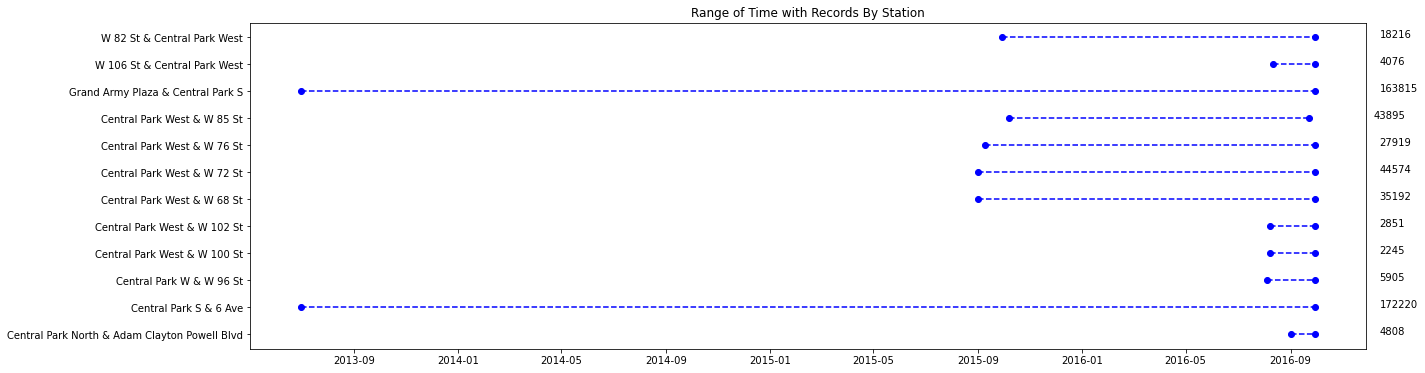

In [95]:
plt.figure(figsize=(20,6))
for i in range(len(overview)):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview['start_station_name'][i], overview['start_station_name'][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    plt.text(x[1]+timedelta(75), y[0], str(overview['total_trips'][i]))
    plt.title('Range of Time with Records By Station')
plt.show()

In [97]:
dates = bq_runner(
    query = f"""
        WITH TRIPS AS(
            SELECT
               start_station_name,
               EXTRACT(DATE from starttime) AS date,
               COUNT(*) AS num_trips
            FROM `{BQ_SOURCE}`
            WHERE start_station_name LIKE '%Central Park%'
            GROUP BY start_station_name, date
        )
        SELECT DISTINCT start_station_name, date
        FROM TRIPS
    """
).to_dataframe()

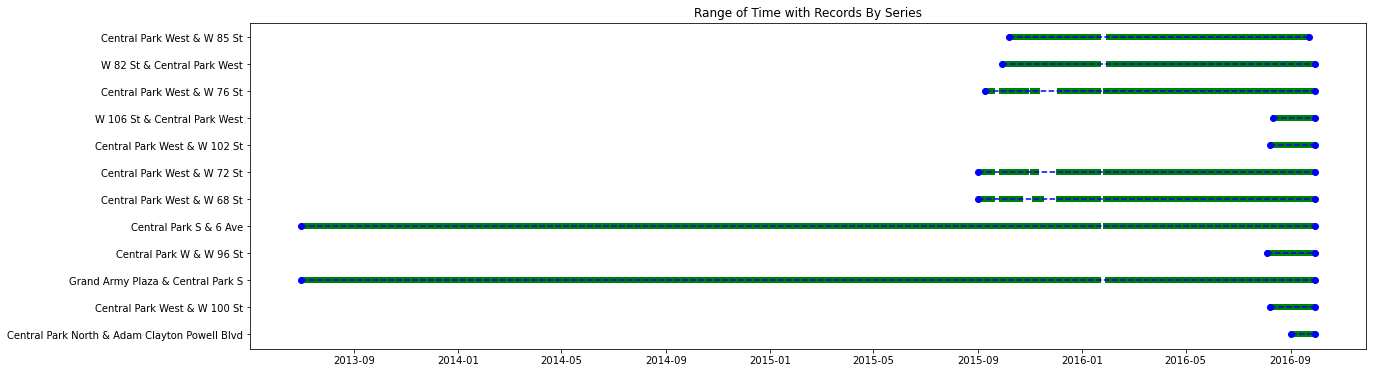

In [98]:
plt.figure(figsize=(20,6))
for i in range(len(overview)):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview['start_station_name'][i], overview['start_station_name'][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    plt.scatter(dates['date'], dates['start_station_name'], c='g', marker='|')
    plt.title('Range of Time with Records By Series')
plt.show()

### Propose Train/Validation/Test Splits by Date Range

Get key dates from the Central Park area stations data while setting the forcast horizon to 2 weeks (14 days):

In [99]:
forecast_granularity = 'DAY'
forecast_horizon = 14
forecast_test_length = 14
forecast_val_length = 14

In [100]:
keyDates = bq_runner(
    query = f"""
        WITH
            ALLDATES AS(
                SELECT EXTRACT(DATE from starttime) as date
                FROM `{BQ_SOURCE}`
                WHERE start_station_name LIKE '%Central Park%'
            ),
            KEYS AS(
                SELECT 
                    MIN(date) as start_date,
                    DATE_SUB(MAX(date), INTERVAL {forecast_test_length+forecast_val_length}-1 DAY) as val_start,
                    DATE_SUB(MAX(date), INTERVAL {forecast_test_length}-1 DAY) as test_start,
                    MAX(date) as end_date
                FROM ALLDATES  
            )
        SELECT *
        FROM KEYS
    """
).to_dataframe()
keyDates

,start_date,val_start,test_start,end_date
0,2013-07-01,2016-09-03,2016-09-17,2016-09-30


Visualize each stations data time range with proposed data segments from key dates:

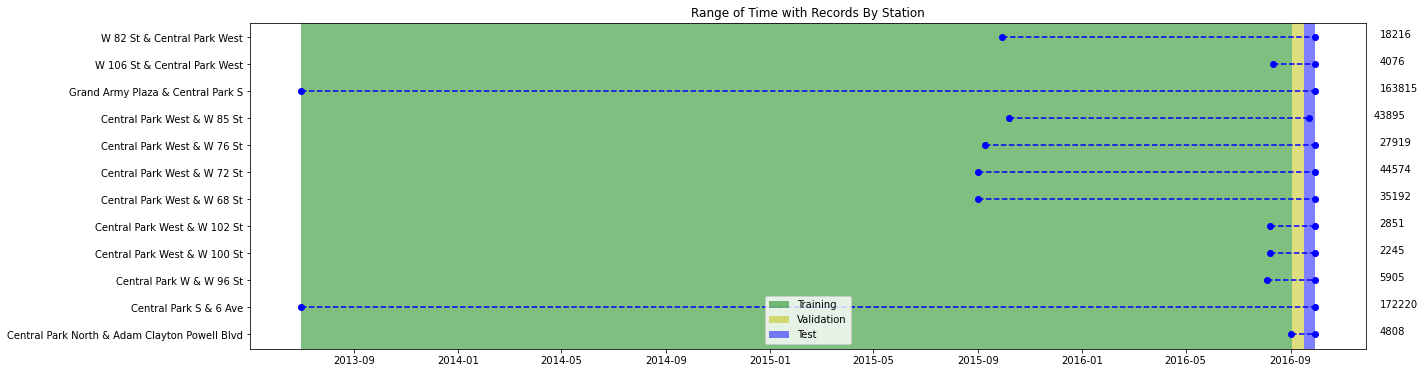

In [101]:
plt.figure(figsize=(20,6))
for i in range(len(overview)):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview['start_station_name'][i], overview['start_station_name'][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    plt.text(x[1]+timedelta(75), y[0], str(overview['total_trips'][i]))
    plt.title('Range of Time with Records By Station')
plt.axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.5, label = 'Training')
plt.axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.5, label = 'Validation')
plt.axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.5, label = 'Test')
plt.legend(loc = 'lower center')
plt.show()

## Create Source BigQuery Table for Forecasting
Put it all together!

In [102]:
job = bq_runner(
    query = f"""
        CREATE OR REPLACE TABLE `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped` AS
        WITH
            DAYS AS(
                SELECT
                   start_station_name,
                   EXTRACT(DATE from starttime) AS date,
                   COUNT(*) AS num_trips
                FROM `{BQ_SOURCE}`
                WHERE start_station_name LIKE '%Central Park%'
                GROUP BY start_station_name, date
            )
        SELECT *,
           CASE
               WHEN date > DATE_SUB((SELECT MAX(date) FROM DAYS), INTERVAL {forecast_test_length} {forecast_granularity}) THEN "TEST"
               WHEN date > DATE_SUB((SELECT MAX(date) FROM DAYS), INTERVAL {forecast_test_length}+{forecast_val_length} {forecast_granularity}) THEN "VALIDATE"
               ELSE "TRAIN"
           END AS splits
        FROM DAYS
    """
)
job.result()
(job.ended-job.started).total_seconds()

2.342

## Review Forecasting Data

In [103]:
splitCounts = bq_runner(
query = f"""
SELECT 
    start_station_name,
    COUNTIF(splits='TRAIN') as TRAIN,
    COUNTIF(splits='VALIDATE') as VALIDATE,
    COUNTIF(splits='TEST') as TEST,
    sum(num_trips) as totalTrips
FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
GROUP BY start_station_name
ORDER BY start_station_name
"""
).to_dataframe()
splitCounts

,start_station_name,TRAIN,VALIDATE,TEST,totalTrips
0,Central Park North & Adam Clayton Powell Blvd,2,14,14,4808
1,Central Park S & 6 Ave,1149,14,14,172220
2,Central Park W & W 96 St,30,14,14,5905
3,Central Park West & W 100 St,26,14,14,2245
4,Central Park West & W 102 St,26,14,14,2851
5,Central Park West & W 68 St,331,14,14,35192
6,Central Park West & W 72 St,334,14,13,44574
7,Central Park West & W 76 St,327,14,14,27919
8,Central Park West & W 85 St,324,14,7,43895
9,Grand Army Plaza & Central Park S,1152,14,13,163815


Totals by data split:

In [105]:
splitCounts[['TRAIN','VALIDATE','TEST']].sum()

TRAIN       4055
VALIDATE     168
TEST         159
dtype: int64

Overall total:

In [106]:
splitCounts[['TRAIN','VALIDATE','TEST']].sum().sum()

4382

Visualize days of data available for forecasting at each station:

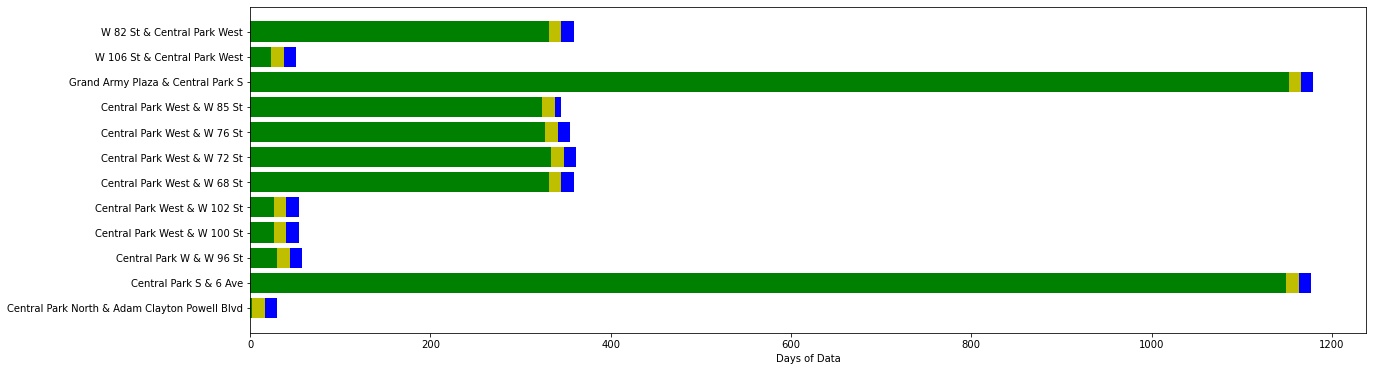

In [107]:
plt.figure(figsize=(20,6))
plt.barh(splitCounts['start_station_name'], splitCounts['TRAIN'], color = 'g')
plt.barh(splitCounts['start_station_name'], splitCounts['VALIDATE'], color = 'y', left = splitCounts['TRAIN'])
plt.barh(splitCounts['start_station_name'], splitCounts['TEST'], color = 'b', left = splitCounts['TRAIN']+splitCounts['VALIDATE'])
plt.xlabel('Days of Data')
plt.show()

## Validation Check: Extract dates for splits from source

In [112]:
keyDates = bq_runner(
    query = f"""
        WITH
            SPLIT AS (
                SELECT splits, min(date) as mindate, max(date) as maxdate
                FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
                GROUP BY splits
            ),
            TRAIN AS (
                SELECT mindate as start_date
                FROM SPLIT
                WHERE splits ='TRAIN'
            ),
            VAL AS (
                SELECT mindate as val_start
                FROM SPLIT
                WHERE splits = 'VALIDATE'
            ),
            TEST AS (
                SELECT mindate as test_start, maxdate as end_date
                FROM SPLIT
                WHERE splits = 'TEST'
            )
        SELECT * EXCEPT(pos) FROM
        (SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
        USING (pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
        USING (pos)
    """
).to_dataframe()
keyDates

,start_date,val_start,test_start,end_date
0,2013-07-01,2016-09-03,2016-09-17,2016-09-30


## Validation Check: Duplicate Dates at Stations?
Are there any stations with data for duplicate dates?

In [113]:
bq_runner(
    query = f"""
    WITH
        DAYS AS (
            SELECT start_station_name, date, count(*) as records
            FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
            GROUP BY start_station_name, date
        )
    SELECT *
    FROM DAYS
    WHERE records > 1
"""
).to_dataframe()

,start_station_name,date,records


## Time Series Review

In [114]:
rawSeries = bq_runner(
    query = f"""
        SELECT 
            start_station_name, date, splits, sum(num_trips) as num_trips
        FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
        GROUP BY start_station_name, date, splits
        ORDER by start_station_name, date
    """
).to_dataframe()

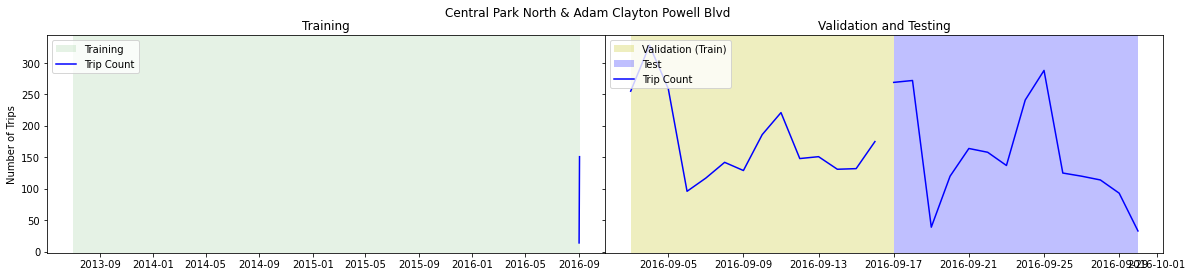

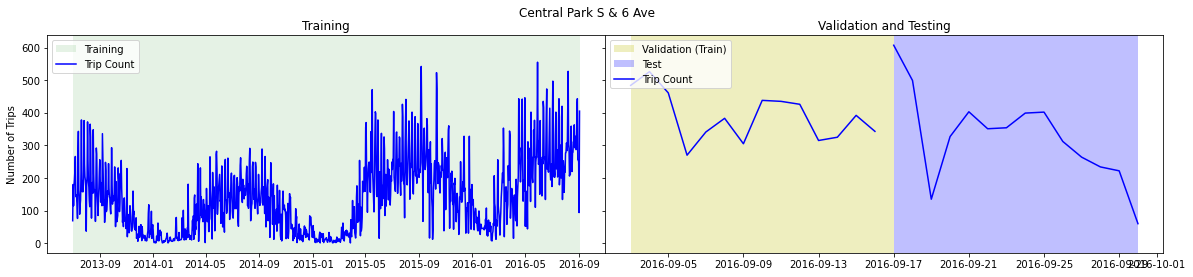

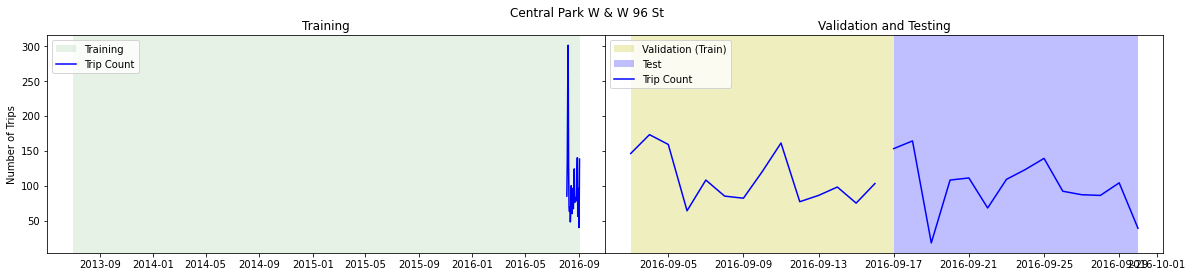

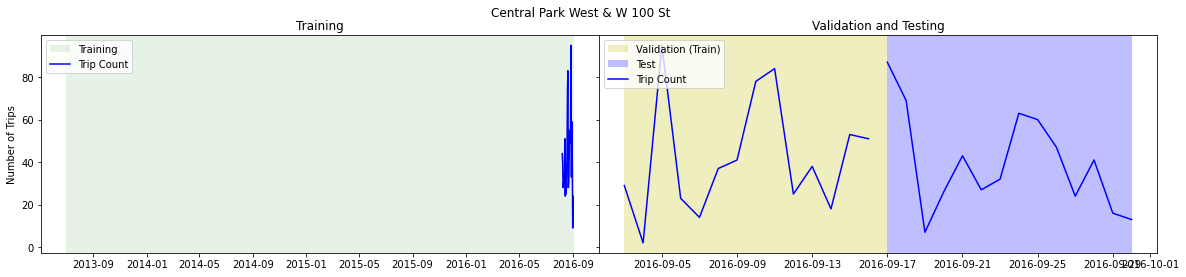

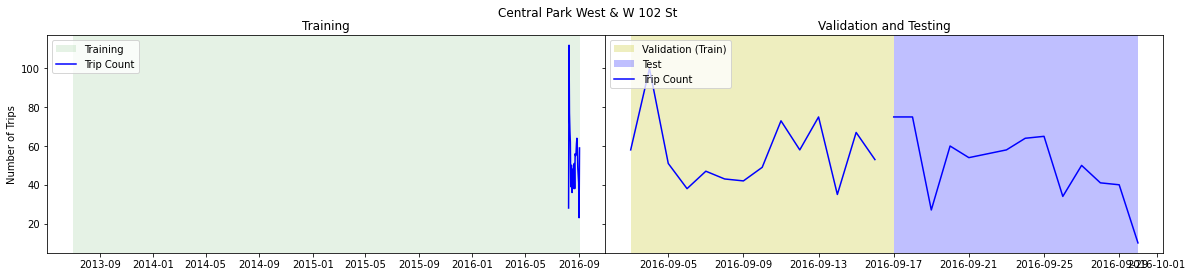

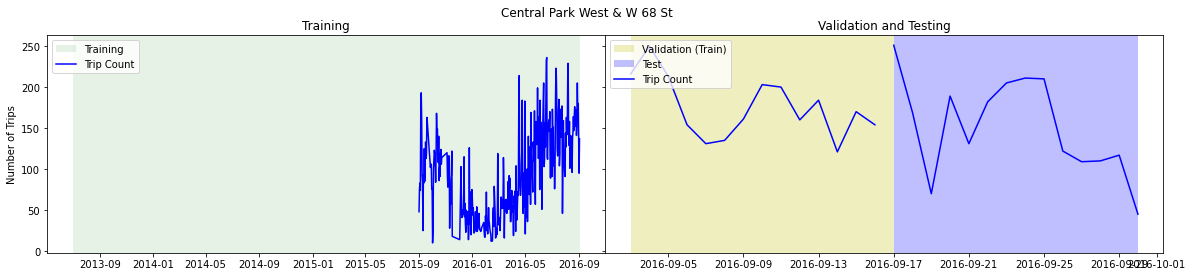

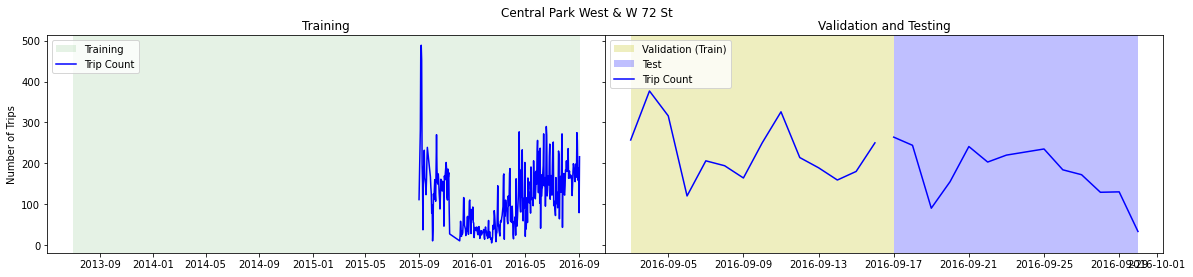

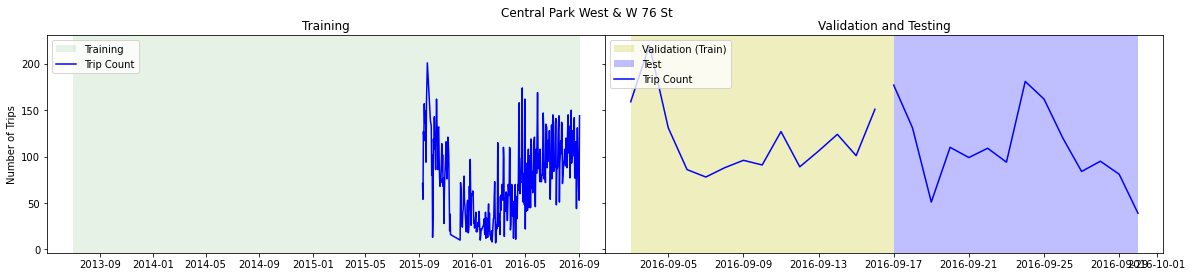

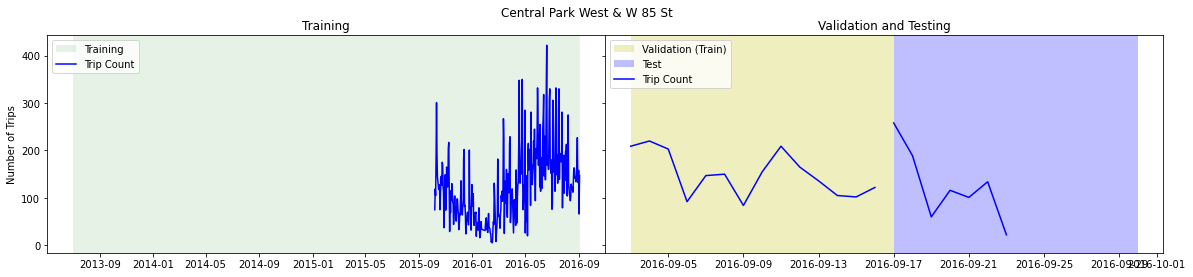

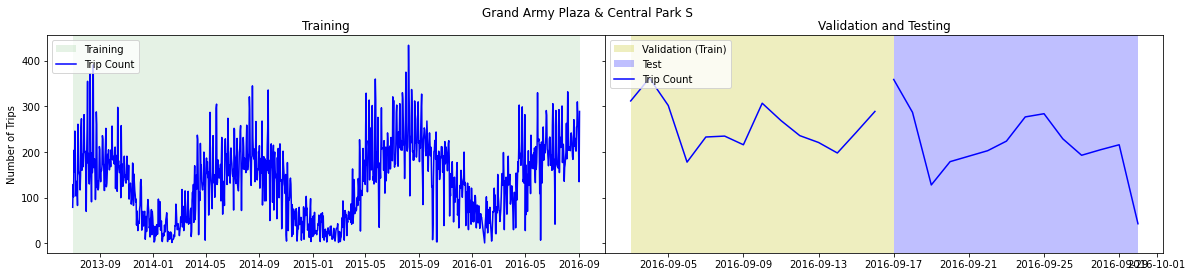

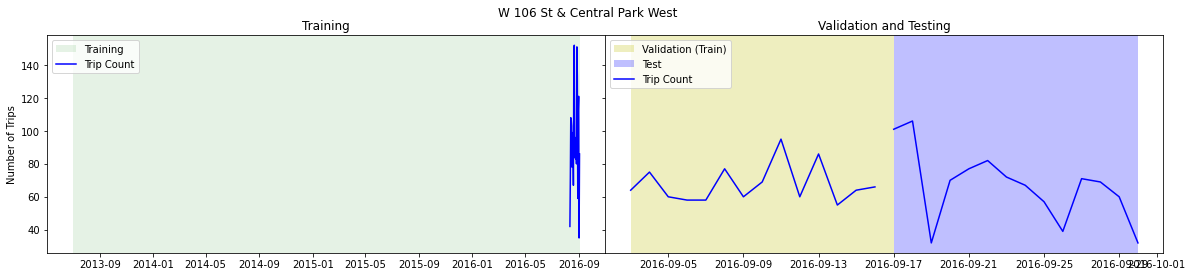

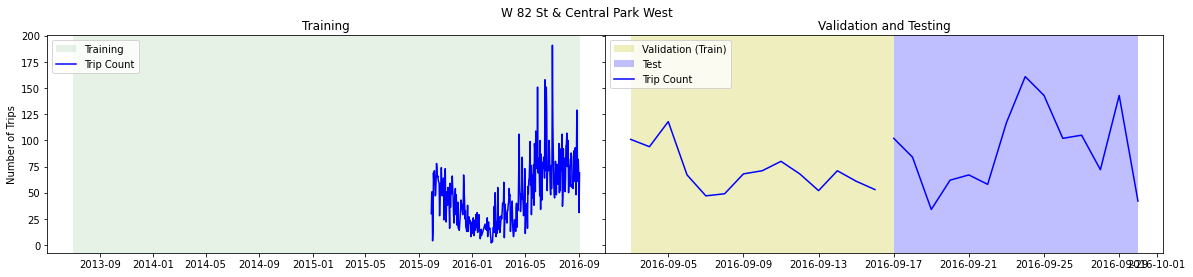

In [115]:
stations = rawSeries['start_station_name'].unique().tolist()
for s, st in enumerate(stations):
    # setup plot area
    fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
    fig.subplots_adjust(wspace=0)
    
    # data
    traindf = rawSeries[(rawSeries['start_station_name'] == st) & (rawSeries['splits'] == 'TRAIN')]
    valdf = rawSeries[(rawSeries['start_station_name'] == st) & (rawSeries['splits'] == 'VALIDATE')]
    testdf = rawSeries[(rawSeries['start_station_name'] == st) & (rawSeries['splits'] == 'TEST')]
    
    # regions
    axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
    axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
    axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')
    
    # lines and dots
    axes[0].plot(traindf['date'], traindf['num_trips'], color = 'b', label = 'Trip Count')
    axes[1].plot(valdf['date'], valdf['num_trips'], color = 'b', label = 'Trip Count')
    axes[1].plot(testdf['date'], testdf['num_trips'], color = 'b')
    
    # labels
    axes[0].set_ylabel('Number of Trips')
    axes[0].set_title('Training')
    axes[1].set_title('Validation and Testing')
    axes[1].legend(loc = 'upper left')
    axes[0].legend(loc = 'upper left')
    plt.suptitle(st)

    # display result
    plt.show()

---
## Remove Resources
see notebook "99 - Cleanup"